<a href="https://colab.research.google.com/github/mohamedbouhamed/Brain-MRI-Images-for-Brain-Tumor-Detection/blob/main/VGG16-for-Brain-MRI-Images%20/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brain MRI Images for Brain Tumour Detection

In [3]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [5]:
!pip install --upgrade kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [6]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
from zipfile import ZipFile
import os

In [20]:
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')
  os.chdir('/content/yes')

Done


In [21]:
from tqdm import tqdm
import cv2

In [26]:
X=[]
y=[]
os.chdir('/content/yes')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      X.append(img)
      y.append('Y')
os.chdir('/content/no')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      img = cv2.resize(img,(224,224))
      X.append(img)
      y.append('N')

100%|██████████| 98/98 [00:00<00:00, 672.84it/s]


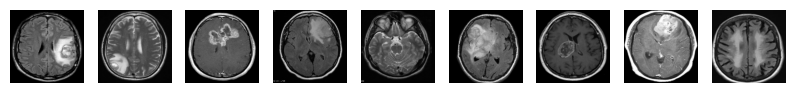

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(1, 9, i+1)
    plt.imshow(X[i*20], cmap="gray")
    plt.axis('off')
plt.show()

In [53]:
import numpy as np
X=np.array(X)
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
le = LabelEncoder()
y=le.fit_transform(y)
y = tf.keras.utils.to_categorical(y, num_classes=2)

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [55]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (169, 224, 224, 3)
X_test Shape:  (84, 224, 224, 3)
y_train Shape:  (169, 2)
y_test Shape:  (84, 2)


In [56]:
from keras.applications import vgg16

# Define the input image size (224x224 pixels, 3 color channels)
img_rows, img_cols = 224, 224

# Load the VGG16 model with ImageNet pre-trained weights, excluding the top fully connected layers
vgg = vgg16.VGG16(weights='imagenet',
                  include_top=False,  # Exclude the top layers (we'll add our own)
                  input_shape=(img_rows, img_cols, 3))  # Define the input image shape

# Freeze the layers of the pre-trained VGG16 model so they are not updated during training
# This allows us to use the learned features without modifying them
for layer in vgg.layers:
    layer.trainable = False  # Set each layer's 'trainable' property to False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [59]:
from tensorflow.keras.models import Model

num_classes = 2

FC_Head = lw(vgg, num_classes)
model = Model(inputs = vgg.input, outputs = FC_Head)
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [60]:
# Compile the model with an optimizer and loss function
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [61]:
history = model.fit(X_train,y_train,
                    epochs=5,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 171s 31s/step - accuracy: 0.5464 - loss: 5.9116 - val_accuracy: 0.7500 - val_loss: 0.5220
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 200s 30s/step - accuracy: 0.6850 - loss: 0.7991 - val_accuracy: 0.4643 - val_loss: 1.1225
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 164s 23s/step - accuracy: 0.6383 - loss: 0.7685 - val_accuracy: 0.7143 - val_loss: 0.6171
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 181s 30s/step - accuracy: 0.8302 - loss: 0.3417 - val_accuracy: 0.7857 - val_loss: 0.5632
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 162s 23s/step - accuracy: 0.8540 - loss: 0.2711 - val_accuracy: 0.8810 - val_loss: 0.4835


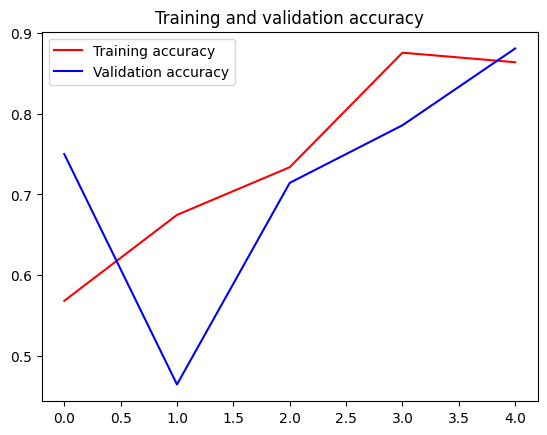

<Figure size 640x480 with 0 Axes>

In [62]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()